In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, Activation, Input, Flatten, concatenate, GlobalAveragePooling2D, LeakyReLU
from keras.models import Model
from keras import backend as K
from keras.layers import Layer, InputSpec
from keras import initializers
import numpy as np
import tensorflow as tf
from visualize_activations import VisualizeActivation


Using TensorFlow backend.


In [2]:
from functools import partial
from bayes_opt import BayesianOptimization

In [3]:
class WeightedAveragePooling(Layer):
    def __init__(self, output_shape, **kwargs):
        self.shape = output_shape
        super(WeightedAveragePooling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='W1', shape=self.shape, initializer='uniform') # creating W

        super(WeightedAveragePooling, self).build(input_shape)

    def call(self, input_):
        w_absolute = K.abs(self.w)  # making w values positive
        numerator = input_*w_absolute
        numerator_sum = K.expand_dims(K.sum(numerator, axis=(1, 2, 3)))
        denominator = K.sum(w_absolute, axis=(1, 2, 3))
        denominator_sum = K.expand_dims(K.sum(w_absolute, axis=(1, 2, 3)))
        return numerator_sum / (denominator_sum + 1e-7)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)
    
    def get_config(self):
        config = {
            'shape': self.shape,
        }
        base_config = super(WeightedAveragePooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
class SWAP(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(SWAP, self).__init__(**kwargs)

    def build(self, input_shape):

        # print(input_shape[-1], self.output_shape_)
        input_dim = input_shape[-1]
        print(type(input_dim))

        self.w = self.add_weight(name='w', shape=(input_dim, self.output_dim), initializer='glorot_normal')
        super(SWAP, self).build(input_shape)

    def call(self, inputs):
        w_ = np.abs(self.w)
        self.w = self.w/(np.sum(w_))
        x = K.dot(inputs, K.abs(self.w))          # weights need to be non negative
        bias_ = -0.5*np.ones(1,)
        output = x + bias_
        output = Activation('sigmoid')(output)

        return output

    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        shape[-1] = self.output_dim
        return tuple(shape)
    
    def get_config(self):
        config = {'output_dim': self.output_dim
                 }
        base_config = super(SWAP, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [5]:
class EyeCalc:
    def __init__(self, input_):
        self.input = input_

    def convolution(self, input_, kernel_size, filters, strides=1, activation='relu', max_pool="True", batch_norm="True"):

        x = Conv2D(kernel_size=kernel_size, filters=filters, strides=strides, padding='same')(input_)

        if activation == 'sigmoid':
            x = Activation('sigmoid')(x)
        else:
            x = Activation('relu')(x)
#             x = LeakyReLU(0.02)(x)

        if batch_norm:
            x = BatchNormalization()(x)

        if max_pool:
            x = MaxPooling2D((2, 2))(x)

        return x

    def conv2d(self):
        num_filters = 64
        x = self.convolution(self.input, 3, num_filters, strides=1)
        for i in range(3):
            num_filters *= 2
            x = self.convolution(x, 3, num_filters, strides=1)
    
        x = self.convolution(x, kernel_size=1, filters=1, strides=1, activation='sigmoid', max_pool=False, batch_norm=False)

        return x

    def pooling(self, input_, type='wap'):
        if type == 'swap':
            x = Flatten()(input_)
            x = SWAP(1)(x)

        else:
            x = WeightedAveragePooling((1, 31, 31, 1))(input_)

        return x

    def forward(self):
        x = self.conv2d()
        x = self.pooling(x, type='swap')

        return x

    def build_model(self):

        output = self.forward()
        model = Model(self.input, output)

        return model


In [6]:
dir = '/home/hitech/Downloads/DRIMDB/'
imgs_path_good = glob.glob(os.path.join(dir, 'Good/*.jpg'))
# print(np.shape(imgs_path_good))
imgs_path_bad = glob.glob(os.path.join(dir, 'Bad/*.jpg'))
# print(np.shape(imgs_path_bad))
images_good= []
images_bad = []
labels_good = []
labels_bad = []

img_size = 128

In [8]:
def image_preprocessing(image):
    img = cv2.resize(image, (img_size, img_size))

    return img


def read_imgs(image_path, good=True):
    image_array = []
    label_array = []
    for image in image_path:
        img = plt.imread(image)
        image_array.append(image_preprocessing(img))
        if good:
            label_array.append(0)
        else:
            label_array.append(1)

    return image_array, label_array



In [9]:

images_good, labels_good = read_imgs(imgs_path_good)
images_bad, labels_bad = read_imgs(imgs_path_bad, good=False)

In [10]:

X = images_good + images_bad
Y = labels_good + labels_bad
# print(np.shape(X), np.shape(Y))
X_final = np.reshape(X, (np.shape(X)[0], np.shape(X)[1], np.shape(X)[2], 3))
Y_final = np.reshape(Y, (np.shape(Y)[0], 1))

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.3)
x_val, x_test2, y_val, y_test_2 = train_test_split(x_test, y_test, test_size=0.5)

In [12]:
datagen = ImageDataGenerator(

        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        rescale=1/255.0
#         width_shift_range=0.1,
#         height_shift_range=0.1
)
datagen.fit(x_train)
# datagen.fit(x_test)


In [13]:
filepath="weights.eyeQual.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
obj = EyeCalc(Input(shape=(img_size, img_size, 3)))
model = obj.build_model()
model.summary()
optimizer = Adam(lr=0.001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
<class 'numpy.int64'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
________________________________________________

In [15]:
batch_size = 8
epochs = 10

In [16]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks_list, steps_per_epoch=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 157s 2s/step - loss: 9.8216 - acc: 0.3837 - val_loss: 0.6181 - val_acc: 0.7119

Epoch 00001: val_acc improved from -inf to 0.71186, saving model to weights.eyeQual.hdf5
Epoch 2/10
100/100 [==============================] - 181s 2s/step - loss: 2.5266 - acc: 0.5586 - val_loss: 0.5356 - val_acc: 0.7966

Epoch 00002: val_acc improved from 0.71186 to 0.79661, saving model to weights.eyeQual.hdf5
Epoch 3/10
100/100 [==============================] - 187s 2s/step - loss: 0.8356 - acc: 0.6279 - val_loss: 0.5441 - val_acc: 0.7797

Epoch 00003: val_acc did not improve from 0.79661
Epoch 4/10
100/100 [==============================] - 189s 2s/step - loss: 0.6158 - acc: 0.7475 - val_loss: 0.6018 - val_acc: 0.7288

Epoch 00004: val_acc did not improve from 0.79661
Epoch 5/10
100/100 [==============================] - 185s 2s/step - loss: 0.6613 - acc: 0.6561 - val_loss: 0.6181 - val_acc: 0.7119

E

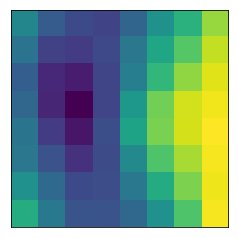

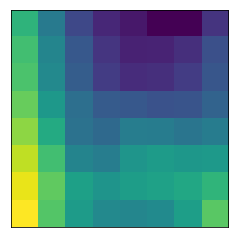

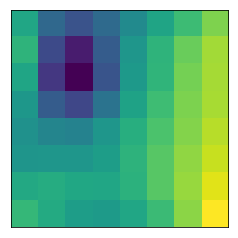

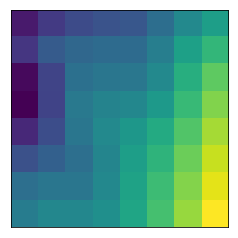

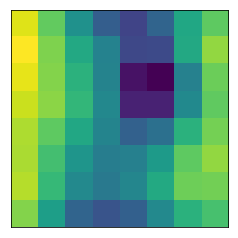

In [64]:
#visualzing the feature map for good images (only 5 samples) 
vis_obj = VisualizeActivation(17,model)
j = 0
for i in imgs_path_good:
    if(j==5):
        break
    else:
        j+=1
        img_test = plt.imread(i)
        img_test = cv2.resize(img_test, (img_size, img_size))
        img_test_ = np.reshape(img_test, (1, img_test.shape[0], img_test.shape[1], img_test.shape[2]))
        plt.figure(figsize=(4,4))
        vis_obj.visualize_feature_maps(img_test_)
        plt.show()



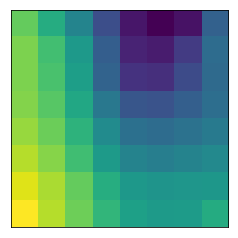

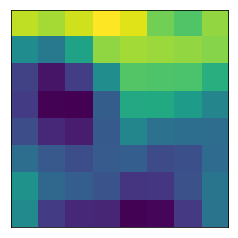

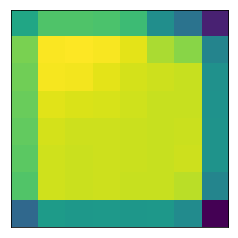

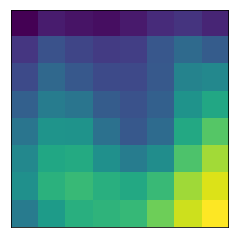

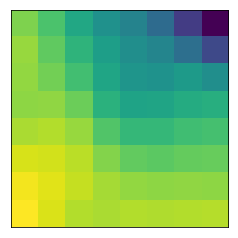

In [62]:
#visualzing the feature map for the bad images

vis_obj = VisualizeActivation(17,model)
j = 0
for i in imgs_path_bad:
    if(j==5):
        break
    else:
        j+=1
        img_test = plt.imread(i)
        img_test = cv2.resize(img_test, (img_size, img_size))
        img_test_ = np.reshape(img_test, (1, img_test.shape[0], img_test.shape[1], img_test.shape[2]))
        vis_obj.visualize_feature_maps(img_test_)
        plt.show()


In [24]:
np.shape(img_test_)

(1, 128, 128, 3)

In [65]:
#evaluation on the test set
model.evaluate(x_test2, y_test_2, steps=10)

10/10 [==============================] - 15s 2s/step


[0.6082744002342224, 0.699999988079071]

In [66]:
y_pred = model.predict(x_test2)

In [78]:
def data_analysis(tp,fp,fn,tn):
    accuracy = (tp + tn)/(tp + tn + fn + fp)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    print("---accuracy---       ", accuracy)
    print("---sensitivity---    ", sensitivity)
    print("---specificity---    ", specificity)
    print("---pos pred value--- ", ppv)
    print("---neg pred value--- ", npv)



In [79]:
for i in range(len(y_pred)):
    if y_pred[i]<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

false_positives = 0
false_negatives = 0
true_positives = 0
true_negatives = 0

for i in range(len(y_pred)):
    if(y_pred[i]==y_test_2[i] and y_test_2[i] == 0):
        true_positives+=1
    if(y_pred[i]==y_test_2[i] and y_test_2[i] == 1):
        true_negatives+=1
    if(y_pred[i]!=y_test_2[i] and y_test_2[i] == 0):
        false_negatives+=1
    if(y_pred[i]!=y_test_2[i] and y_test_2[i] == 1):
        false_positives+=1

data_analysis(true_positives, false_positives, false_negatives, true_negatives)


---accuracy---        0.7
---sensitivity---     1.0
---specificity---     0.1
---pos pred value---  0.6896551724137931
---neg pred value---  1.0


#### accuracy is 70%
#### sensitivity is 100 % i.e percentage of positive values that should have been predicted positive
#### specificity is 10% i.e percentage of negative values that should have been predicted negative. This means that for smaller image size, more bad images are predicted as good images
#### positive predictive value is 68.9% -  probability that the sample that returns a positive result really is positive
#### negative predicted value is 100% - probability that the sample that returns a negative result really is negative

In [84]:
def fit_with(lr):

    obj = EyeCalc(Input(shape=(img_size, img_size, 3)))
    model = obj.build_model()
    model.summary()
    optimizer = Adam(lr=lr)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Evaluate the model with the eval dataset.
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=1, validation_data=(x_val, y_val), callbacks=callbacks_list, steps_per_epoch=100)
   

    score = model.evaluate(x_test2,y_test_2, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Return the accuracy.

    return score[1]

from functools import partial

verbose = 1
fit_with_partial = partial(fit_with)

In [85]:
    pbounds = {'lr': (1e-4, 1e-2)}

In [86]:
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10,)


for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |    lr     |
-------------------------------------
<class 'numpy.int64'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_13 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 128)       73856     
____________________________________________

KeyboardInterrupt: 

#### the hyperparamter optimization code takes a lot of time on my CPU. Therefore, the process was stopped in between. Basically I have tried to implement Bayesian optimization. I could have gone for Random Search or Grid Search but that would have taken a longer time. Moreover, they are more random in their approach. Bayesian technique will try to take a calculative step for the next hyperparameter value